<a href="https://colab.research.google.com/github/kelsierorz/DLBOI/blob/main/113_DLBOI_Homework3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
import torch.nn as nn
import torch.optim as optims

from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms.functional import InterpolationMode

In [ ]:
device = torch.device('cuda')
gpu_count = torch.cuda.device_count()

print("Using", gpu_count, "GPUs")
print("CUDA is available:", torch.cuda.is_available())

Using 1 GPUs
CUDA is available: True


In [ ]:
# train loop
def train_one_epoch(model, device, criterion, optimizer, train_data_loader):
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()

    model.train()

    for batch_idx, (images, labels) in enumerate (train_data_loader):
        images = images.to(device)
        labels = labels.to(device).float()
        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, labels.unsqueeze(1))

        # Calculating Loss
        epoch_loss.append(loss.item())

        # Calculating Metrics
        predicts = (preds > 0.5).float()
        predicts = predicts.view(-1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)

        epoch_acc.append(acc)

        # Backpropagation
        loss.backward()
        optimizer.step()

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100

    return epoch_loss, epoch_acc, total_time

# validation loop
def val_one_epoch(model, device, criterion, val_data_loader, best_acc, save):
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device).float()
            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels.unsqueeze(1))
            epoch_loss.append(loss.item())

            # Calculating Metrics
            predicts = (preds > 0.5).float()
            predicts = predicts.view(-1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100

    # Saving best model
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        torch.save(model.state_dict(), f"{save}.pth")

    return epoch_loss, epoch_acc, total_time, best_acc

# evaluate loop (test loop)
def evaluate(model, device, model_path, test_loader):
    try:
        model.load_state_dict(torch.load(model_path))
        print("Model weights loaded successfully.")
    except Exception as e:
        print("Warning: Failed to load model weights. Using randomly initialized weights instead.")
        print(e)

    model.to(device)
    model.eval()

    test_loss = []
    test_acc = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).float()

            # Forward pass
            preds = model(images)

            # Calculating loss
            loss = criterion(preds, labels.unsqueeze(1))
            test_loss.append(loss.item())

            # Calculating accuracy
            predicts = (preds > 0.5).float()
            predicts = predicts.view(-1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            test_acc.append(acc)

    # Overall test results
    avg_test_loss = np.mean(test_loss)
    avg_test_acc = np.mean(test_acc) * 100

    print(f"Test Accuracy: {avg_test_acc:.2f}%")
    print(f"Test Loss: {avg_test_loss:.4f}")

    return avg_test_loss, avg_test_acc

# Data Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# define folder path for each set
train_path = '/content/drive/MyDrive/BIOLAB/chest_xray/train'
test_path = '/content/drive/MyDrive/BIOLAB/chest_xray/test'
val_path = '/content/drive/MyDrive/BIOLAB/chest_xray/val'

# define transformation
train_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=InterpolationMode.BICUBIC),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

common_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=InterpolationMode.BICUBIC),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

# create datasets
train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
test_dataset = datasets.ImageFolder(test_path, transform=common_transform)
val_dataset = datasets.ImageFolder(val_path, transform=common_transform)

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model

In [ ]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(256 * 256 * 1, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.7),

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.7),

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.7),

    nn.Linear(64, 1),
    nn.Sigmoid()
)

model.to(device)
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=65536, out_features=64, bias=True)
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0.7, inplace=False)
  (5): Linear(in_features=64, out_features=64, bias=True)
  (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.7, inplace=False)
  (9): Linear(in_features=64, out_features=64, bias=True)
  (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Dropout(p=0.7, inplace=False)
  (13): Linear(in_features=64, out_features=1, bias=True)
  (14): Sigmoid()
)


# Loop

In [ ]:
# hyperparameter
lr = 0.0001
weight_decay = 0.001
optimizer = optims.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
lr_scheduler = optims.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3, mode='max')
epochs = 20
criterion = nn.BCELoss()

# save checkpoint
save = 'model'

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_acc = 0.0
output_list = []

for epoch in range(epochs):
    train_loss, train_acc, train_time = train_one_epoch(model, device, criterion, optimizer, train_loader)
    val_loss, val_acc, val_time, best_acc = val_one_epoch(model, device, criterion, val_loader, best_acc, save)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    total_time = train_time + val_time
    output_str = f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - train_acc: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_acc: {val_acc:.2f}% - time: {total_time:.2f}s"
    output_list.append(output_str)
    print(output_str)
    lr_scheduler.step(val_acc)

Epoch 1/20 - loss: 0.1950 - train_acc: 95.31% - val_loss: 0.2728 - val_acc: 93.75% - time: 62.46s
Epoch 2/20 - loss: 0.1903 - train_acc: 95.21% - val_loss: 0.3900 - val_acc: 81.25% - time: 63.10s
Epoch 3/20 - loss: 0.1886 - train_acc: 95.31% - val_loss: 0.2239 - val_acc: 93.75% - time: 61.52s
Epoch 4/20 - loss: 0.1709 - train_acc: 95.56% - val_loss: 0.5609 - val_acc: 68.75% - time: 63.06s
Epoch 5/20 - loss: 0.1673 - train_acc: 96.19% - val_loss: 0.2458 - val_acc: 93.75% - time: 61.85s
Epoch 6/20 - loss: 0.1625 - train_acc: 96.73% - val_loss: 0.2173 - val_acc: 93.75% - time: 63.27s
Epoch 7/20 - loss: 0.1592 - train_acc: 95.85% - val_loss: 0.2081 - val_acc: 100.00% - time: 62.07s
Epoch 8/20 - loss: 0.1606 - train_acc: 96.63% - val_loss: 0.2045 - val_acc: 100.00% - time: 62.78s
Epoch 9/20 - loss: 0.1596 - train_acc: 96.00% - val_loss: 0.2076 - val_acc: 93.75% - time: 61.47s
Epoch 10/20 - loss: 0.1642 - train_acc: 96.19% - val_loss: 0.2089 - val_acc: 93.75% - time: 63.03s
Epoch 11/20 - los

# Graph

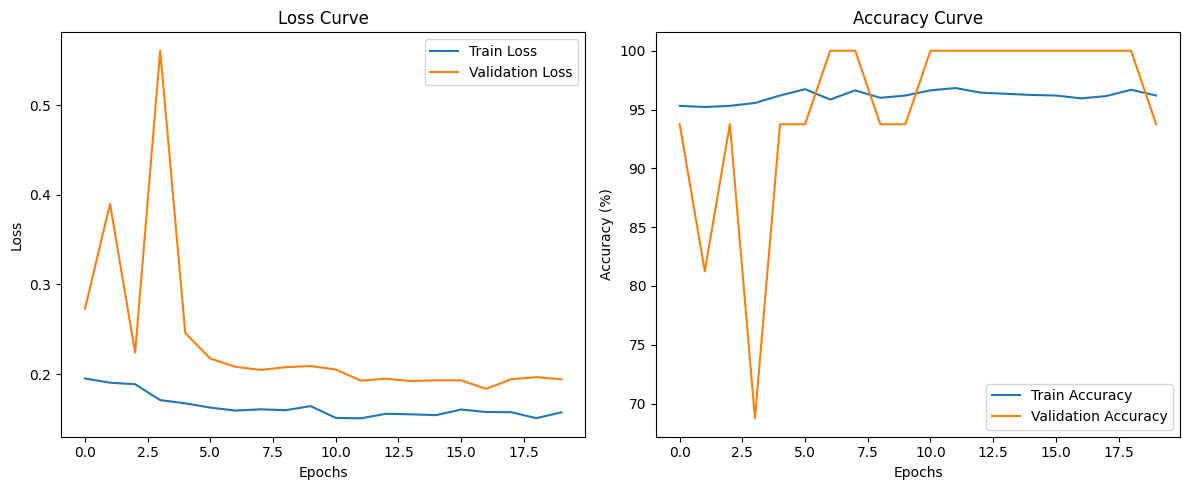

In [ ]:
plt.figure(figsize=(12, 5))

# loss graph
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy graph
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# show
plt.tight_layout()
plt.show()

# Evaluate

In [ ]:
model_path = 'model.pth'
avg_test_loss, avg_test_acc = evaluate(model, device, model_path, test_loader)